<a href="https://colab.research.google.com/github/Aquib88raza/image-classification-ANKLE/blob/main/svm%2Bdensenet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201  # Import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [8]:

# Define the path to your image directories for healthy and ill samples
normal_path = "/content/drive/MyDrive/Y2022AnkleCLEAN/normal"
ill_path = "/content/drive/MyDrive/Y2022AnkleCLEAN/ill"

# Create lists to store image data and labels
dataset_images = []
dataset_labels = []

# Reading images from the normal directory
for files in os.listdir(normal_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(normal_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            dataset_images.append(image)
            dataset_labels.append(0)  # Label for healthy images

# Reading images from the ill directory
for files in os.listdir(ill_path):
    if files.endswith(".jpg"):
        file_path = os.path.join(ill_path, files)
        image = cv2.imread(file_path)
        if image is not None and not image.size == 0:
            size = (256, 256)  # Define the size for resizing images
            image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
            dataset_images.append(image)
            dataset_labels.append(1)  # Label for ill images

# Convert the lists to NumPy arrays
dataset_images = np.array(dataset_images)
dataset_labels = np.array(dataset_labels)

# Normalize pixel values to the range [0, 1]
dataset_images = dataset_images / 255.0

seed = 42  # You can use any integer value as the seed

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset_images, dataset_labels, test_size=0.1, random_state=seed)

# Load a pre-trained DenseNet model (DenseNet161 in this case) without the top classification layers
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(256, 256, 3))  # Use keras.applications.densenet


74836368/74836368 [==============================] - 0s 0us/step


Epoch 1/10
5/5 [==============================] - 103s 19s/step - loss: 0.6798 - accuracy: 0.5688 - val_loss: 0.6732 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 69s 14s/step - loss: 0.7620 - accuracy: 0.5312 - val_loss: 0.6359 - val_accuracy: 0.6111
Epoch 3/10
5/5 [==============================] - 64s 13s/step - loss: 0.6730 - accuracy: 0.5875 - val_loss: 0.6081 - val_accuracy: 0.7222
Epoch 4/10
5/5 [==============================] - 63s 13s/step - loss: 0.6726 - accuracy: 0.6125 - val_loss: 0.5945 - val_accuracy: 0.7222
Epoch 5/10
5/5 [==============================] - 64s 13s/step - loss: 0.6393 - accuracy: 0.6313 - val_loss: 0.5760 - val_accuracy: 0.7778
Epoch 6/10
5/5 [==============================] - 66s 14s/step - loss: 0.6003 - accuracy: 0.6562 - val_loss: 0.5446 - val_accuracy: 0.7778
Epoch 7/10
5/5 [==============================] - 63s 13s/step - loss: 0.5838 - accuracy: 0.7125 - val_loss: 0.5195 - val_accuracy: 0.7778
Epoch 8/10
5/5 [==========

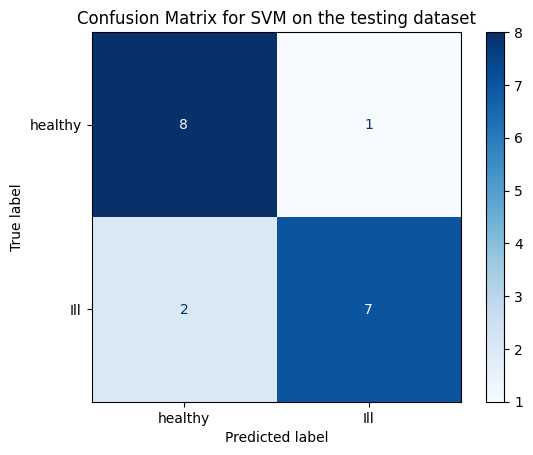

In [9]:
# Create a new model by adding your own classification layers on top of the pre-trained DenseNet
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Freeze the layers of the pre-trained DenseNet
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training dataset
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Extract features from the model for both training and testing datasets
X_train_features = model.predict(X_train)
X_test_features = model.predict(X_test)

# Define the parameter grid for the grid search
svm_param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [1, 10, 50, 70, 100],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}

# Create an instance of the SVM classifier
svm_classifier = SVC()

# Perform the grid search using GridSearchCV
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=svm_param_grid, scoring='accuracy', cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train_features, y_train)

# Get the best parameters found by the grid search
best_params = grid_search.best_params_
print("Best SVM Parameters:", best_params)

# Train an SVM classifier with the best parameters on the training dataset
best_svm_classifier = SVC(**best_params)
best_svm_classifier.fit(X_train_features, y_train)

# Predict on the testing dataset
y_test_pred = best_svm_classifier.predict(X_test_features)

# Generate a classification report for the testing dataset
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for SVM on the testing dataset:\n", test_report)

# Calculate the confusion matrix for the testing dataset
test_cm = confusion_matrix(y_test, y_test_pred)


# Display the confusion matrix for the testing dataset
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=["healthy", "Ill"])
test_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM on the testing dataset")
plt.show()

Epoch 1/10
5/5 [==============================] - 66s 14s/step - loss: 0.5354 - accuracy: 0.7125 - val_loss: 0.4796 - val_accuracy: 0.7778
Epoch 2/10
5/5 [==============================] - 67s 14s/step - loss: 0.5380 - accuracy: 0.7375 - val_loss: 0.4647 - val_accuracy: 0.7778
Epoch 3/10
5/5 [==============================] - 67s 14s/step - loss: 0.5338 - accuracy: 0.7750 - val_loss: 0.4578 - val_accuracy: 0.7778
Epoch 4/10
5/5 [==============================] - 68s 14s/step - loss: 0.5395 - accuracy: 0.7875 - val_loss: 0.4497 - val_accuracy: 0.8333
Epoch 5/10
5/5 [==============================] - 68s 14s/step - loss: 0.5407 - accuracy: 0.7312 - val_loss: 0.4437 - val_accuracy: 0.8333
Epoch 6/10
5/5 [==============================] - 68s 14s/step - loss: 0.4979 - accuracy: 0.7750 - val_loss: 0.4448 - val_accuracy: 0.7778
Epoch 7/10
5/5 [==============================] - 62s 13s/step - loss: 0.4872 - accuracy: 0.7875 - val_loss: 0.4483 - val_accuracy: 0.7778
Epoch 8/10
5/5 [===========

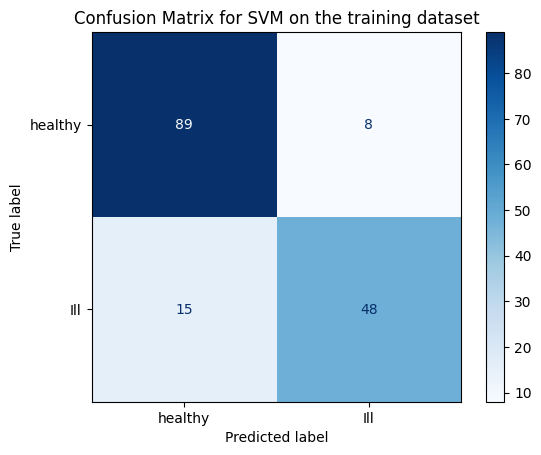

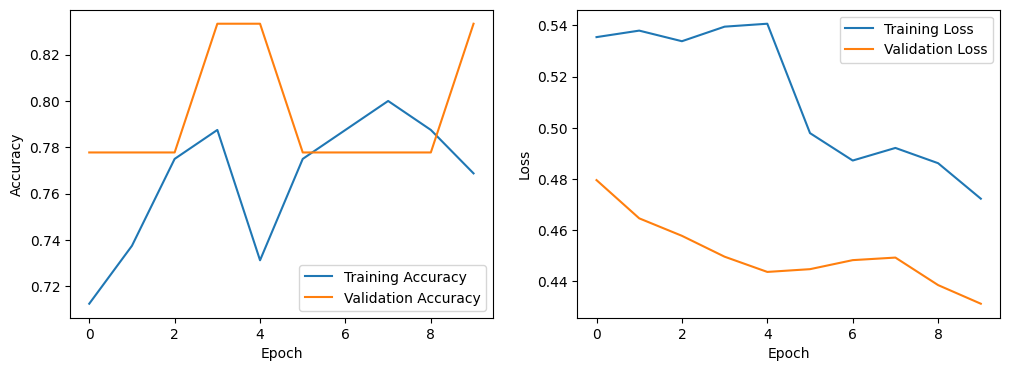

In [10]:

# Train the model on the training dataset
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Extract features from the model for both training and testing datasets
X_train_features = model.predict(X_train)
X_test_features = model.predict(X_test)

# Create and train the SVM classifier on the extracted features
svm_classifier = SVC()
svm_classifier.fit(X_train_features, y_train)

# Predict on the training dataset
y_train_pred = svm_classifier.predict(X_train_features)

# Generate a classification report for the training dataset
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for SVM on the training dataset:\n", train_report)

# Calculate the confusion matrix for the training dataset
train_cm = confusion_matrix(y_train, y_train_pred)

# Display the confusion matrix for the training dataset
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=["healthy", "Ill"])
train_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM on the training dataset")
plt.show()

# Plot the learning curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
